# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/human_body_temperature.csv')
pop_mean = 98.6 

## Is the distribution of body temperatures normal?

In [4]:
# Examine head of dataframe
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


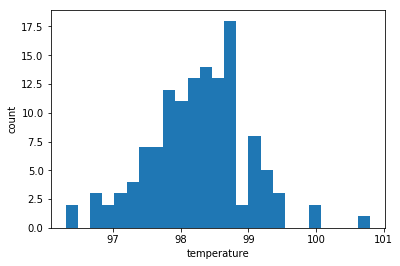

In [5]:
# Use a histogram to visualize the data distribution
_ = plt.hist(df['temperature'], bins=25)
_ = plt.xlabel('temperature')
_ = plt.ylabel('count')
plt.show()

The distribution of the body temperatures does not appear to be normally distributed. Next, compare to Normal PDF and normal curve using ECDF and KDE Plots.

### Compare to a Normal PDF and Normal Curve

In [6]:
# Function to calculate ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    # np.arange(1, len(x)+1) / len(x)
    y = np.arange(1, n+1) / n

    return x, y

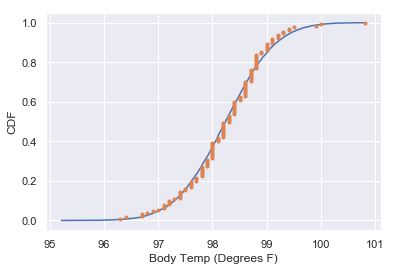

In [7]:
# Create a one-dimensional NumPy array of temperatures
bodytemp = df['temperature']

mean = np.mean(bodytemp)
std = np.std(bodytemp)
samples = np.random.normal(mean, std, size=10000)
x, y = ecdf(bodytemp) #ecdf function
x_theor, y_theor = ecdf(samples) 

# Plot both distributions
sns.set()
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Body Temp (Degrees F)')
_ = plt.ylabel('CDF')

plt.show()

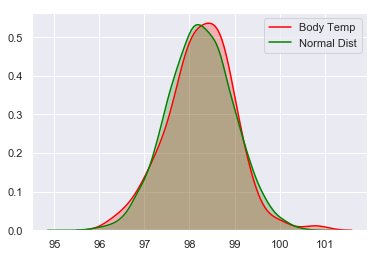

In [8]:
# Use sns.kdeplot to compare the curves
sns.kdeplot(bodytemp, color='red', label='Body Temp', shade=True)
sns.kdeplot(x_theor, color='green', label='Normal Dist', shade=True)
plt.legend()
plt.show()

Using the computed mean and std dev to check against the theoretical distribution using both the ECDF and the normal distribution curve tell us that the distribution of the the body temperatures is indeed normal (although there may be some question as to whether the tail is "light tailed").

## Is the sample size large? Are the observations independent?
At a sample size of 130, the sample is large, as many references to the CLT list n=30 as "large enough".

The observations are independent, as one sample has no effect on the the other.

In [70]:
# Get descriptive statistics about the dataframe
desc = df.describe()
type(desc)
samp_cnt = int(desc['temperature'][0])
samp_mean = desc['temperature'][1]
samp_std = desc['temperature'][2]
pop_mean = 98.6
print('sample population = ', int(samp_cnt))
print('sample mean = ', samp_mean)
print('sample std dev = ', samp_std)

sample population =  130
sample mean =  98.24923076923078
sample std dev =  0.7331831580389454


## Is the true population mean really 98.6 degrees F?
### Bootstrap hypothesis test
H0: The mean body temperature in the sample is not the true population mean (98.6F).
H1: The mean body temperature in the sample is actually true population mean (98.6F).

In [85]:
def bootstrap_replicate_1d(data, func):
    """Function accepts a data set and function; returns the result of the function on the data set."""
    bs_sample = np.random.choice(data, len(data))
    
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def diff_from_pop_mean(data, pop_mean = 98.6):
    return np.mean(data) - pop_mean

# shift the sample data
shifted_bodytemp = bodytemp - np.mean(bodytemp) + 98.6
# calculate the test statistic
diff_obs = diff_from_pop_mean(bodytemp)
print('Difference of observed mean and population mean = ', round(diff_obs, 4))

# compute the p-value
bs_replicates = draw_bs_reps(shifted_bodytemp, diff_from_pop_mean, 10000)
p_value = np.sum(bs_replicates <= diff_obs) / 10000
print('p = ', p_value)

Difference of observed mean and population mean =  -0.3508
p =  0.0


The bootstrap hypothesis test has a p-value of 0.0, so we can reject the null hypothesis and conclude that the observed sample is the same as the population mean.

### Frequentist testing
You would use a **one-sample hypothesis test**, as we only have one data set, and we're comparing it to a single number (the population mean)

In this situation, it would be appropriate to use the **t statistic**, as the standard deviation of the population is not known.

### t-test

In [74]:
### Perform a t-test
# H0: There is a difference between the sample mean and the population mean
# H1: There is no difference between the sample mean and the population mean

from scipy import stats

# Create a one-dimensional NumPy array of temperatures
bodytemp = df['temperature'].values

#pop_mean = 98.6

# Conduct a one-sample t-test
result = stats.ttest_1samp(bodytemp, pop_mean)

print("t statistic = ", result[0])
print("p value = ", result[1])
type(bodytemp)

t statistic =  -5.4548232923645195
p value =  2.4106320415561276e-07


numpy.ndarray

The p-value is 0.00000024106320415561276, so we can reject the null hypothesis and say that there is no difference between the sample mean and the population mean.

### z-test
Now try using the the z-test. How is the result be different? Why?

In [75]:
# Demonstrating significant differences between a
# vector of measurements and a single value
# Using the statsmodels package for doing test
# Using numpy to generate some fake data

from statsmodels.stats import weightstats as stests
bodytemp = df['temperature'].values

# Assuming data are normally distributed, we can do z-test
testResult=stests.ztest(bodytemp,value=pop_mean)
pValue=testResult[1]
zStat=testResult[0] 
print("p-value is: "+str(pValue))
print("z-statistic is "+str(zStat))

p-value is: 4.9021570141012155e-08
z-statistic is -5.4548232923645195


For the z-test, the test statistics are the same, but the p-value (0.000000049021570141012155) is the slightly different than the t-test.  However, when rounded, they are essentially the same - 0.00.

For sample sizes over 30, we will get the same result between the z-test and t-test.

## Repeat z- and t-tests
Draw a small sample of size 10 from the data and repeat both frequentist tests.
Which one is the correct one to use?
What do you notice? What does this tell you about the difference in application of the  𝑡  and  𝑧  statistic?

In [93]:
# take a random sample of 10 from the bodytemp
np.random.seed(6)
sample = np.random.choice(a=bodytemp, size=10)
print(sample)

[97.  97.3 97.6 97.  98.8 98.2 98.  98.4 98.8 98.4]


## t-test

In [63]:
### Perform a t-test
# H0: There is a difference between the sample mean and the population mean
# H1: There is no difference between the sample mean and the population mean
#pop_mean = 98.6

# Conduct a one-sample t-test
tStat = stats.ttest_1samp(sample, pop_mean)

print("t-statistic = ", tStat[0])
print("p-value = ", tStat[1])

t-statistic =  -2.985898864351592
p-value =  0.015302397503358064


In [62]:
# Perform a z-test
testResult=stests.ztest(sample,value=pop_mean)
zStat=testResult[0] 
pValue=testResult[1]
print("z-statistic is "+str(zStat))
print("p-value is: "+str(pValue))

z-statistic is -2.985898864351592
p-value is: 0.0028274613689639465


With a sample of 10 and an unknown population standard deviation, the appropriate test to use for a sample this size is a t-test.

Both tests have the same test statistic (-2.985898864351592), and both have a p-value < .05. These results tell me that there is little difference between the t-test and z-test in conditions such as these.

### Confidence Intervals

**At what temperature should we consider someone's temperature to be "abnormal"?**

As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.  

Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

## Frequentist Approach
Calculate the confidence intervals using the frequentist approach

In [52]:
# 95% CI, so split 5% in half for each end of the interval (-2.5/+2.5; i.e., 2.5 and 97.5)
conf_int = np.percentile(bodytemp, [2.5, 97.5])
print(conf_int)

[96.7225 99.4775]


In [95]:
#The 68% confidence interval for a single draw from a normal distribution with mean mu and std deviation sigma is

stats.norm.interval(0.95, loc=samp_mean, scale=samp_std)

(96.81221818540311, 99.68624335305844)

## Using Bootstrap Approach
Calculate the confidence intervals using the bootstrap approach

## ** NEED TO RE-DO - LOOK AT CIs **

In [91]:
# Use the previously-defined function for generating one bootstrap replicates, using the previously calculated 'bs_replicates'
# bootstrap_replicate_1d(), draw_bs_reps(), diff_from_pop_mean()

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

#print(shifted_bodytemp)

# Print the confidence interval
print('95% confidence interval =', conf_int)

95% confidence interval = [-0.12461538  0.12384615]


In [92]:
bs_replicates

array([ 0.00230769,  0.05692308,  0.04538462, ..., -0.02461538,
       -0.02769231, -0.09846154])

## Gender Differences
Is there a significant difference between males and females in normal temperature?  

What testing approach did you use and why?  

Write a story with your conclusion in the context of the original problem.

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000
